# 1 Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import itertools
import random # split datasets

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# lightgbm
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# 2 Load datasets

In [2]:
train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')


In [3]:
print(train.shape)
print(test.shape)

(590540, 289)
(506691, 289)


For avoiding LightGBM error: 
`LightGBMError: Do not support special JSON characters in feature name.`, rename the features

In [4]:
import re
train = train.rename(columns = lambda x:re.sub(':', '', x))
test = test.rename(columns = lambda x:re.sub(':', '', x))

Train / Validation Split

In [5]:
y = pd.DataFrame(train['isFraud'])
X = train.drop(columns=['isFraud'])
X_test = test.drop(columns=['isFraud'])

In [6]:
index_array = np.arange(len(X))
val_index = index_array[random.sample(range(0,X.shape[0]), X.shape[0]//5)]
train_index = np.delete(index_array[:X.shape[0]], val_index, axis=0)
len(train_index), len(val_index)

(472432, 118108)

In [7]:
X_train, X_val = X.iloc[train_index], X.iloc[val_index]
y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# 3 Modeling
## 3.1 XGboost
### 3.1.1 Training

In [8]:
%%time

prediction_test_fold = []

param = {'booster' : 'gbtree',
         'max_depth' : 8, #14
         'nthread' : -1,
         'num_class' : 1,
         'objective' : 'binary:logistic',
         'silent' : 1,
         'eval_metric' : 'auc',
         'eta' : 0.01,
         'tree_method' : 'gpu_hist',
         'min_child_weight' : 0,
         'colsample_bytree' : 0.8,
         'colsample_bylevel' : 0.8,
         'seed' : 2019}



    
print("Train Shape :", X_train.shape,
      "Validation Shape :", X_val.shape,
      "Test Shape :", X_test.shape)
    
dtrn = xgb.DMatrix(X_train, label=y_train, feature_names = X.columns)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = X.columns)
dtst = xgb.DMatrix(X_test, feature_names = X.columns)
    
xgb1 = xgb.train(param, dtrn, num_boost_round=10000, evals = [(dtrn, 'train'), (dval, 'eval')],
                 early_stopping_rounds = 200, verbose_eval=200)
                 
prediction_XGB = xgb1.predict(dtst) # prediction of test
#prediction_test_fold.append(prediction_XGB)

prediction_val_XGB = xgb1.predict(xgb.DMatrix(X_val, feature_names = X.columns)) # prediction of validation

Train Shape : (472432, 288) Validation Shape : (118108, 288) Test Shape : (506691, 288)
[17:29:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.81697	eval-auc:0.81063
[200]	train-auc:0.89139	eval-auc:0.88470
[400]	train-auc:0.92270	eval-auc:0.90717
[600]	train-auc:0.94456	eval-auc:0.92368
[800]	train-auc:0.95423	eval-auc:0.93242
[1000]	train-auc:0.95917	eval-auc:0.93687
[1200]	train-auc:0.96346	eval-auc:0.94067
[1400]	train-auc:0.96698	eval-auc:0.94364
[1600]	train-auc:0.96986	eval-auc:0.94613
[1800]	train-auc:0.97210	eval-auc:0.94789
[2000]	train-auc:0.97418	eval-auc:0.94962
[2200]	train-auc:0.97623	eval-auc:0.95146
[2400]	train-auc:0.97773	eval-auc:0.95272
[2600]	train-auc:0.97918	eval-auc:0.95396
[2800]	train-auc:0.98060	eval-auc:0.95515
[3000]	train-auc:0.98206	eval-auc:0.95641
[3200]	train-auc:0.98318	eval-auc:0.95716
[3400]	tr

### 3.1.2 Confusion matrix

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
metrics.accuracy_score(y_val, prediction_val_XGB.round())*100

98.62498729975954

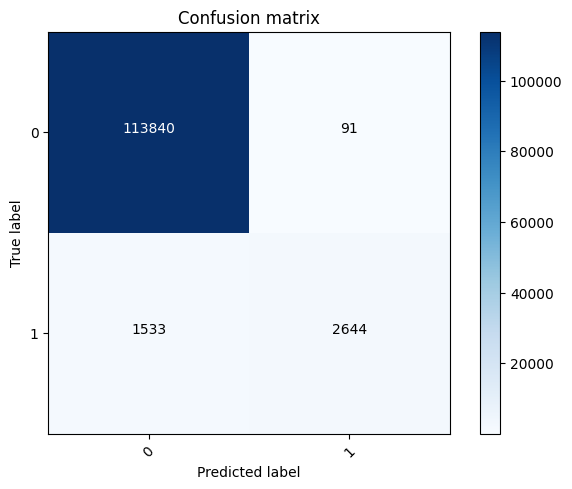

In [11]:
confusion_mtx = confusion_matrix(y_val, prediction_val_XGB.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

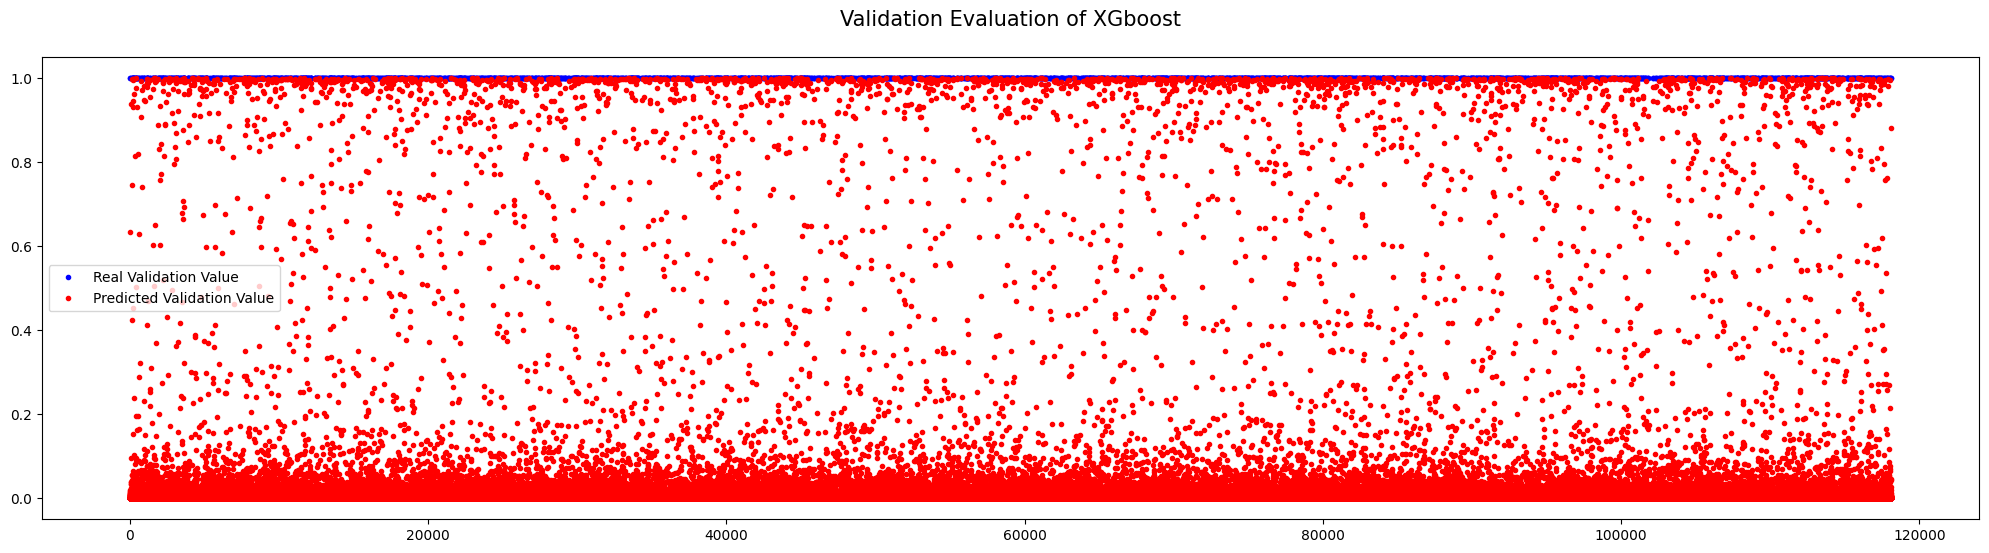

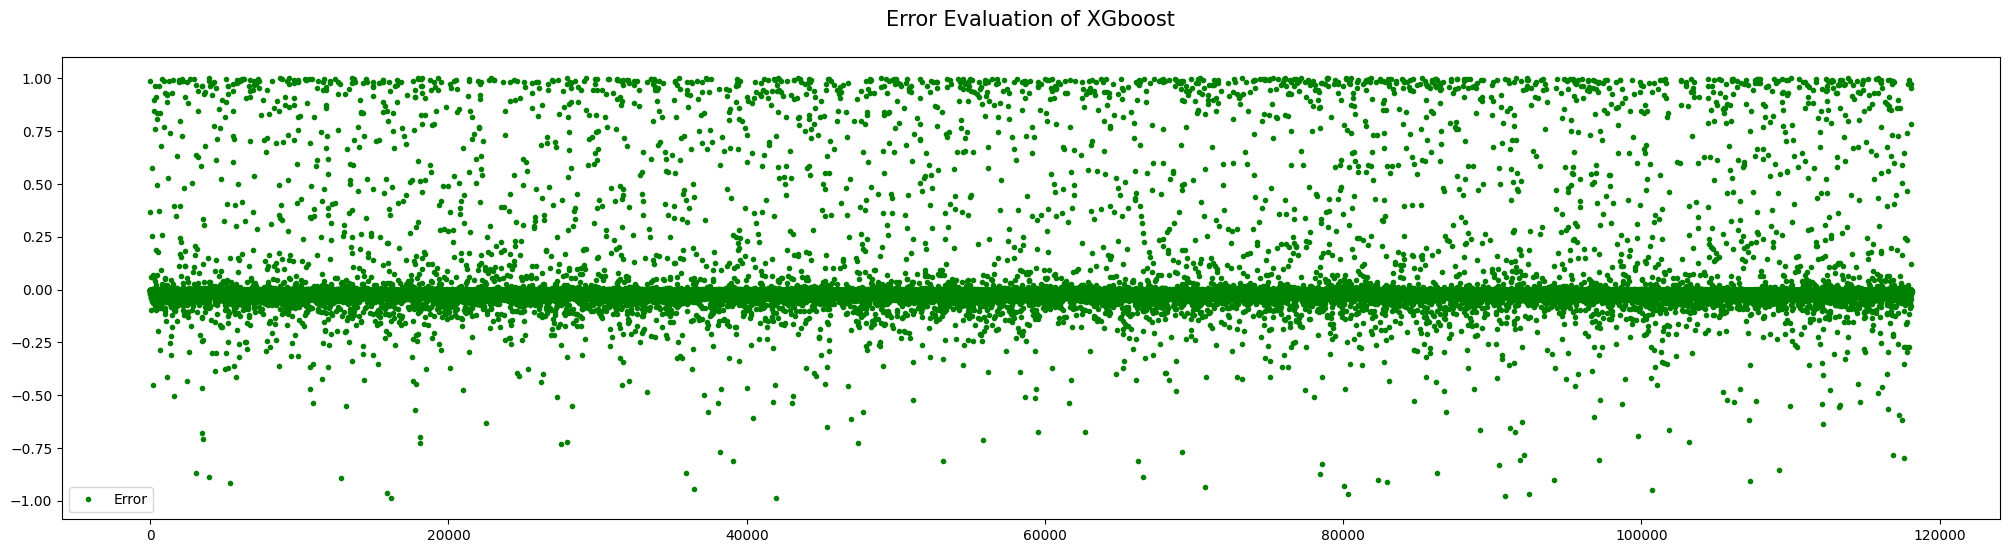

In [12]:
plt.figure(figsize = (25,6))
plt.title('Validation Evaluation of XGboost', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'], '.', label = 'Real Validation Value', color = 'blue')
plt.plot(prediction_val_XGB, '.', label = 'Predicted Validation Value', color = 'red')
plt.legend()
plt.show()

plt.figure(figsize = (25,6))    
plt.title('Error Evaluation of XGboost', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'] - prediction_val_XGB, '.', label = 'Error', color = 'green')
plt.legend()
plt.show()

## 3.2 LightGBM
### 3.2.1 Training

In [13]:
%%time

params = {'num_leaves': 500,
          'min_child_weight': 0.03,
          'feature_fraction': 0.35,
          'bagging_fraction': 0.35,
          'min_data_in_leaf': 100,
          'objective': 'binary',
          'max_depth': 14,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 10,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.2,
          'reg_lambda': 0.6,
          'random_state': 50,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }


dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=200)
    

prediction_LGB = model.predict(X_test)
prediction_val_LGB = model.predict(X_val)

c:\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.937879	valid_1's auc: 0.916776
[200]	training's auc: 0.955038	valid_1's auc: 0.929508
[300]	training's auc: 0.967993	valid_1's auc: 0.939295
[400]	training's auc: 0.976536	valid_1's auc: 0.946525
[500]	training's auc: 0.981861	valid_1's auc: 0.951688
[600]	training's auc: 0.985399	valid_1's auc: 0.955555
[700]	training's auc: 0.987801	valid_1's auc: 0.958122
[800]	training's auc: 0.989562	valid_1's auc: 0.960269
[900]	training's auc: 0.990843	valid_1's auc: 0.961886
[1000]	training's auc: 0.991806	valid_1's auc: 0.963231
[1100]	training's auc: 0.992652	valid_1's auc: 0.96425
[1200]	training's auc: 0.993312	valid_1's auc: 0.965074
[1300]	training's auc: 0.993983	valid_1's auc: 0.965881
[1400]	training's auc: 0.994544	valid_1's auc: 0.966619
[1500]	training's auc: 0.994959	valid_1's auc: 0.967161
[1600]	training's auc: 0.99536	valid_1's auc: 0.967704
[1700]	training's auc: 0.995701	valid_1's auc: 0.9681

### 3.2.2 Confusion matrix

In [14]:
metrics.accuracy_score(y_val, prediction_val_LGB.round())*100

98.76130321400753

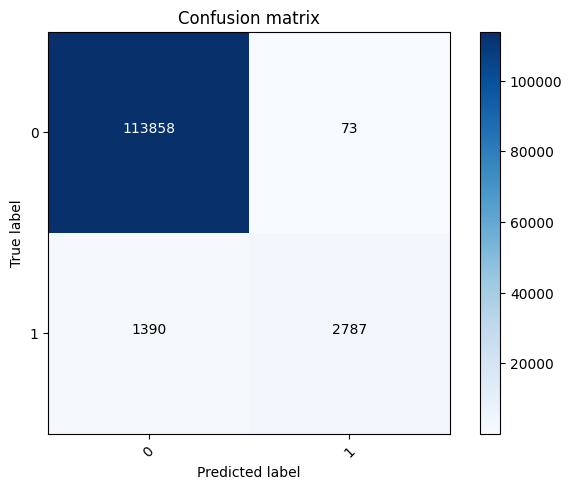

In [15]:
confusion_mtx = confusion_matrix(y_val, prediction_val_LGB.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

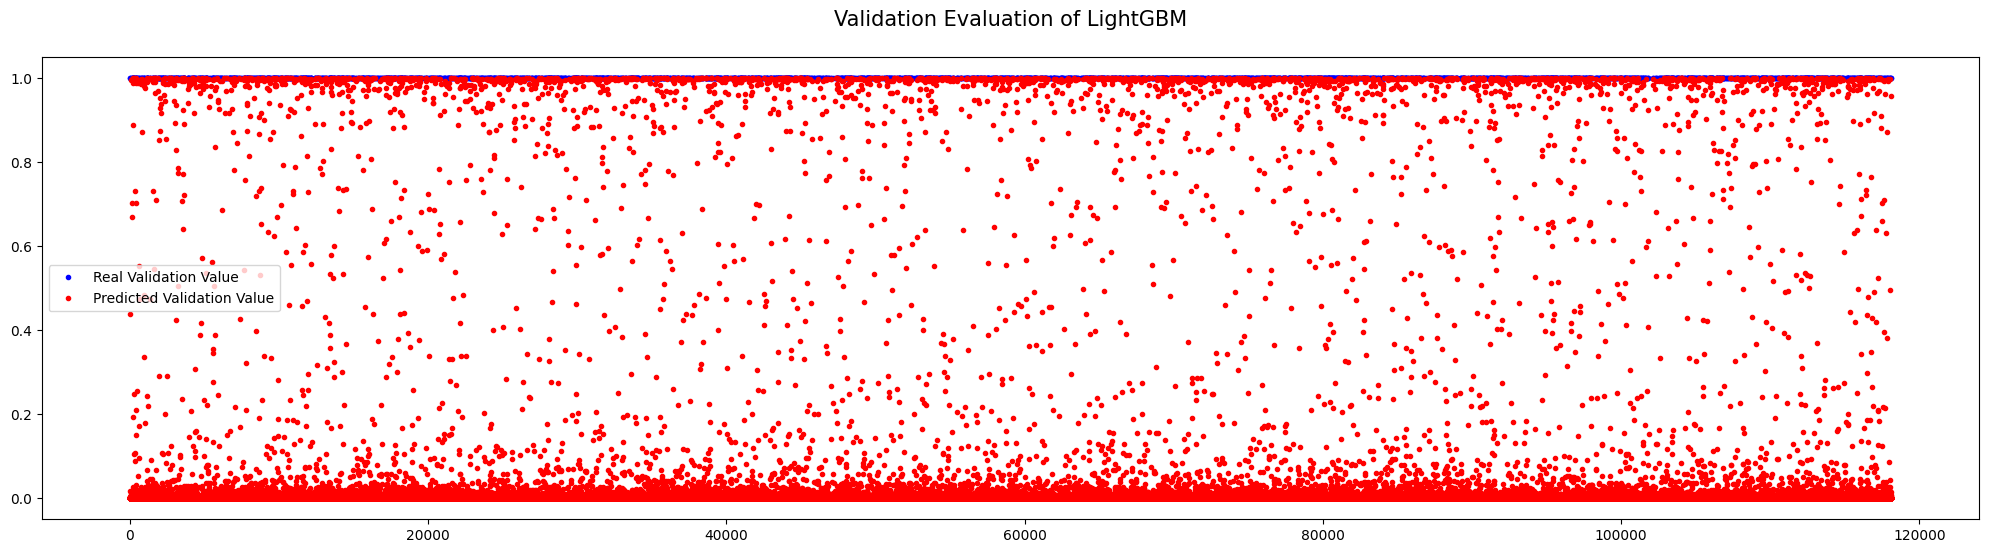

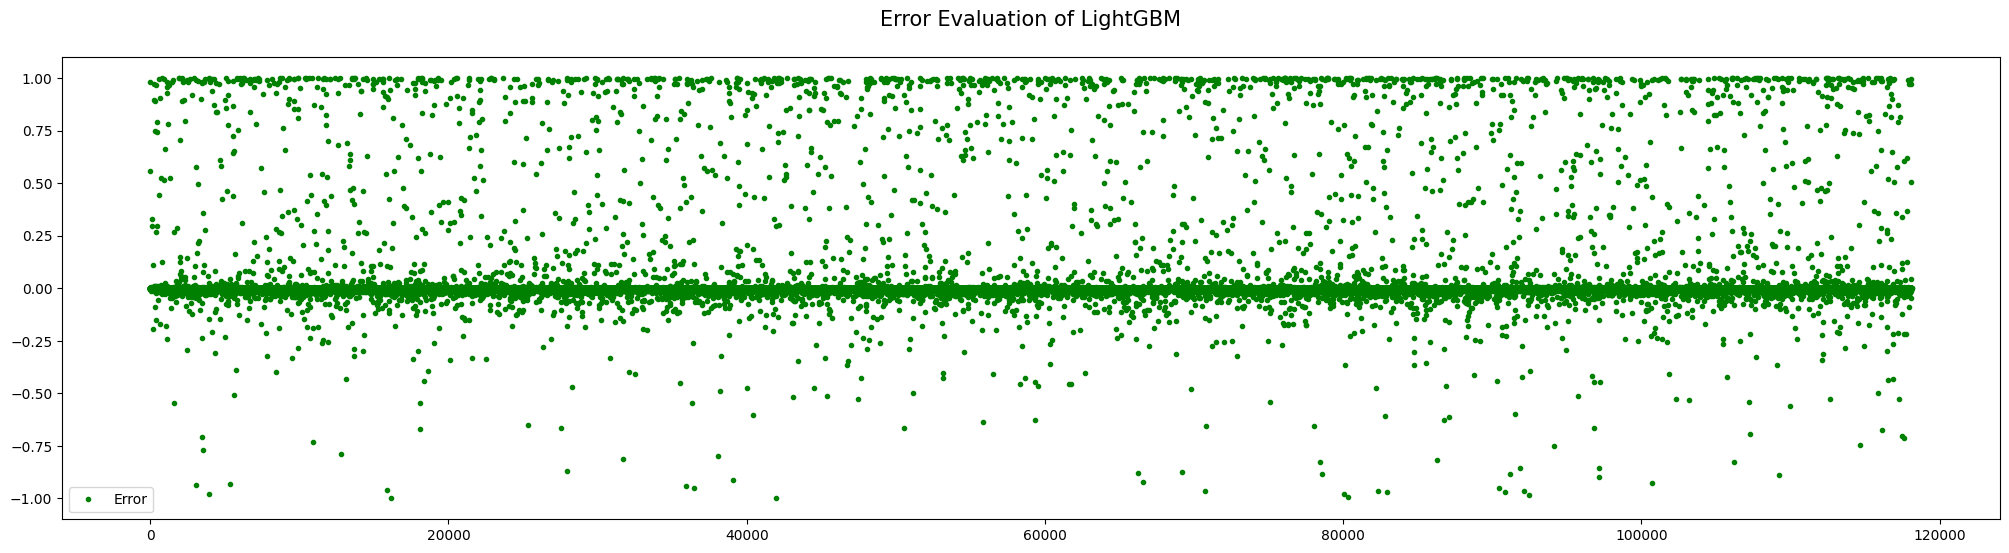

In [16]:
plt.figure(figsize = (25,6))
plt.title('Validation Evaluation of LightGBM', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'], '.', label = 'Real Validation Value', color = 'blue')
plt.plot(prediction_val_LGB, '.', label = 'Predicted Validation Value', color = 'red')
plt.legend()
plt.show()

plt.figure(figsize = (25,6))    
plt.title('Error Evaluation of LightGBM', y = 1.05, size = 15)
plt.plot(y_val.reset_index()['isFraud'] - prediction_val_LGB, '.', label = 'Error', color = 'green')
plt.legend()
plt.show()

# 4 Submission

In [17]:
sample_submission = pd.read_csv('input/sample_submission.csv', index_col='TransactionID')

In [18]:
sample_submission.shape

(506691, 1)

In [19]:
sample_submission['isFraud'] = np.nan
sample_submission.head()

,isFraud
TransactionID,
3663549,NaN
3663550,NaN
3663551,NaN
3663552,NaN
3663553,NaN


In [20]:
xgb_sub, lgb_sub = sample_submission, sample_submission

## 4.1 XGboost

In [21]:
xgb_sub['isFraud'] = (0.5 * prediction_XGB) + (0.5 * prediction_XGB)
xgb_sub.head()

,isFraud
TransactionID,
3663549,0.000621
3663550,0.000112
3663551,0.000144
3663552,0.000098
3663553,0.000148


In [22]:
xgb_sub[xgb_sub['isFraud'] > 0.1]

,isFraud
TransactionID,
3663769,0.734225
3663780,0.108966
3663811,0.121282
3663827,0.389538
3663828,0.179083
...,...
4170032,0.260585
4170059,0.344869
4170078,0.656466


In [23]:
xgb_sub.to_csv('submission/sample_xgboost.csv')

## 4.2 LightGBM

In [24]:
lgb_sub['isFraud'] = (0.5 * prediction_LGB) + (0.5 * prediction_LGB)
lgb_sub.head()

,isFraud
TransactionID,
3663549,0.000138
3663550,0.000020
3663551,0.000093
3663552,0.000050
3663553,0.000006


In [25]:
lgb_sub[xgb_sub['isFraud'] > 0.1]

,isFraud
TransactionID,
3663769,0.932748
3663821,0.100388
3663827,0.810895
3663828,0.462807
3663836,0.900340
...,...
4170021,0.999581
4170059,0.470272
4170069,0.101570


In [26]:
lgb_sub.to_csv('submission/sample_lightgbm.csv')